In [1]:
%matplotlib inline
import os
import time
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.model_selection import train_test_split
from PIL import Image
import pickle
import scipy
#import cv2
from PIL import ImageOps
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

Using TensorFlow backend.


In [3]:
IMG_WIDTH, IMG_HEIGHT = 200, 200
nb_train_samples = 4125
nb_validation_samples = 466 
batch_size = 25
epochs = 15

data_size = 30000
columns = ["image_name","popularity_score","partial_faces","is_female","baby","child","teenager","youth","middle_age","senior","white","black","asian","oval_face","round_face","heart_face","smiling","mouth_open","frowning","wearing_glasses","wearing_sunglasses","wearing_lipstick","tongue_out","duck_face","black_hair","blond_hair","brown_hair","red_hair","curly_hair","straight_hair","braid_hair","showing_cellphone","using_earphone","using_mirror","braces","wearing_hat","harsh_lighting","dim_lighting"]

In [4]:
def load_dataset():
    path_to_file = "Selfie-dataset/selfie_dataset.txt"
    data = pd.read_csv(path_to_file, sep=" ", header=None, encoding='utf-8')
    print(type(data))
    data.columns = columns
    #data = data[["image_name", "popularity_score", "is_female", "baby", "child", "teenager", "youth", "middle_age","senior"]]
    return data

In [5]:
data = load_dataset()

<class 'pandas.core.frame.DataFrame'>


In [6]:
data.head()

,image_name,popularity_score,partial_faces,is_female,baby,child,teenager,youth,middle_age,senior,...,curly_hair,straight_hair,braid_hair,showing_cellphone,using_earphone,using_mirror,braces,wearing_hat,harsh_lighting,dim_lighting
0,00a454da495e11e28a7322000a1fa414_6,3.901,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,00cddb96ac4c11e3a30212279ba1b65f_6,4.385,1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,01cdd7aa1a1a11e2aaa822000a1fb0dd_6,4.243,-1,1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,024696bead0c11e389d50ec42b3b1b1c_6,4.169,-1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,026df048221a11e2b52122000a1fa4b5_6,3.873,-1,1,-1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,-1


In [7]:
seed = 123 
X_train, X_test, y_train, y_test = train_test_split(data['image_name'][:data_size], data.iloc[:, 1:][:data_size], test_size=0.15, random_state=seed)

In [8]:
def  get_im_PIL(filename):
    img_pil = Image.open(filename)
    img_pil = img_pil.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
    #img_pil = ImageOps.box_blur(img_pil, radius=1)
    #img_pil = img_pil.transpose(Image.FLIP_LEFT_RIGHT)
    return np.asarray(img_pil)

def load_train(file=False, name=""):
    '''
    read the image and return the data
    main folder shoud be split into data and code
    put the images in Selfie-dataset/images
    '''
    X_train = []
    X_train_id = []
    y_train = []
    start_time = time.time()
    folders = ["Selfie-dataset/images"]
    if(file):
        for fld in folders:
            files=[]
            files.append(os.path.join(fld, name+'.jpg'))
            for fl in files:
                flbase = os.path.basename(fl)
                img = get_im_PIL(fl)
                X_train.append(img)
                X_train_id.append(flbase)
        return X_train
    else:
        for fld in folders:
            path = os.path.join('..',fld, '*.jpg')
            files = glob.glob(path)
            for fl in files[:100]:
                flbase = os.path.basename(fl)
                img = get_im_cv2(fl)
                X_train.append(img)
                X_train_id.append(flbase)

        return X_train


def read_and_normalize_train_data(file=False,name=""):
    '''
    read the image or the whole dataset
    return - normalised numpy array 
    '''
    train_data = load_train(file,name)

    train_data = np.array(train_data, dtype=np.uint8)


    train_data = train_data.astype('float32')
    train_data = train_data / 255

    return train_data

In [9]:
def get_data(X, Y):
    X = np.array(X)
    Y = np.array(Y)
    Y = (Y+1)/2
    data_list = []
    popularity = []
    classes = []
    for i in range(len(X)):
        data_list.append((read_and_normalize_train_data(file=True, name=X[i])[0]))
        popularity.append(Y[i][0])
        classes.append(Y[i][1:])
    output = [np.array(popularity), np.array(classes)]
    return np.array(data_list), output

In [10]:
X_train, y_train = get_data(X_train, y_train)

In [11]:
X_test, y_test = get_data(X_test, y_test)

In [12]:
def multitask_loss(y_true, y_pred):
    # Avoid divide by 0
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    # Multi-task lossmodel.summary()
    return K.mean(K.sum(- y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred), axis=1))

In [13]:
def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2*((p*r)/(p+r+K.epsilon()))



In [14]:
def modify_resnet(model):
    for layer in model.layers[:30]:
        layer.trainable = False

    #Adding custom Layers 
    x = model.output
    x = Flatten()(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation="relu")(x)
    
    regression_head = Dense(1, activation='linear', name="regression")(x)
    classification_head = Dense(y_train[1].shape[1], activation="sigmoid", name='classification')(x)

    # creating the final model 
    model_final = Model(input = model.input, output = [regression_head, classification_head])

    # compile the model 
    model_final.compile(loss = ['mean_squared_error', 'binary_crossentropy'], 
                        optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), 
                        metrics={'regression':['mean_squared_error'],'classification':[f1, precision, recall,"binary_accuracy"]})
    return model_final

In [15]:
from keras.models import load_model
try:
    model = load_model('trained_model.hdf5')
except:
    model = applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape=(200, 200, 3), pooling=None, classes=1000)
    model = modify_resnet(model)
    model.save("model_untrained.hdf5")

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`
  app.launch_new_instance()


In [16]:
hist = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.20, verbose=1,class_weight ={'baby':161,'child':39,'teenager':4,'youth':1,'middle_age':28,'senior':1978})

Train on 20400 samples, validate on 5100 samples
Epoch 1/15
20400/20400 [==============================] - 213s 10ms/step - loss: 0.8765 - regression_loss: 0.4330 - classification_loss: 0.4436 - regression_mean_squared_error: 0.4330 - classification_f1: 0.4050 - classification_precision: 0.4569 - classification_recall: 0.3874 - classification_binary_accuracy: 0.8053 - val_loss: 0.4639 - val_regression_loss: 0.1011 - val_classification_loss: 0.3628 - val_regression_mean_squared_error: 0.1011 - val_classification_f1: 0.4980 - val_classification_precision: 0.6130 - val_classification_recall: 0.4203 - val_classification_binary_accuracy: 0.8634
Epoch 2/15
20400/20400 [==============================] - 218s 11ms/step - loss: 0.5300 - regression_loss: 0.1713 - classification_loss: 0.3587 - regression_mean_squared_error: 0.1713 - classification_f1: 0.4434 - classification_precision: 0.5700 - classification_recall: 0.3642 - classification_binary_accuracy: 0.8522 - val_loss: 0.6581 - val_regress

Epoch 15/15
20400/20400 [==============================] - 224s 11ms/step - loss: 0.3514 - regression_loss: 0.0414 - classification_loss: 0.3100 - regression_mean_squared_error: 0.0414 - classification_f1: 0.5014 - classification_precision: 0.6505 - classification_recall: 0.4094 - classification_binary_accuracy: 0.8684 - val_loss: 1.4849 - val_regression_loss: 1.1477 - val_classification_loss: 0.3372 - val_regression_mean_squared_error: 1.1477 - val_classification_f1: 0.4841 - val_classification_precision: 0.6164 - val_classification_recall: 0.3995 - val_classification_binary_accuracy: 0.8628


In [17]:
model.save('trained_model.hdf5')

In [18]:
import json
#json.dump(hist.history, open('history_simple.json','w'))
#model.summary()


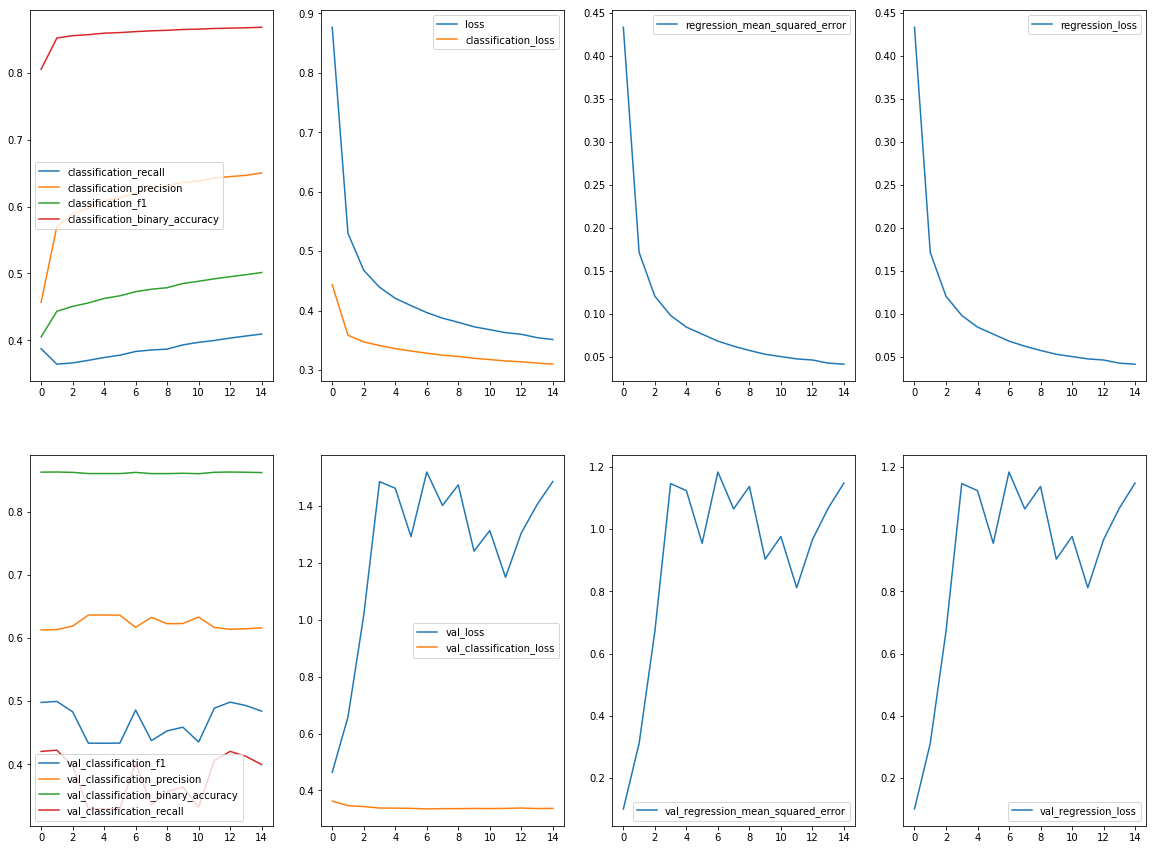

In [19]:
def plot_history(h):
    fig, axes = plt.subplots(2,4, figsize=(20,15))
    x = range(len(h['classification_loss']))

    for key, series in h.items():
        a, target = -1, 0
        if 'val' in key:
            a = 1
        else:
            a = 0
        if 'regression' in key:
            target += 2
        if 'loss' in key:
            target += 1

        if target != -1:
            axes[a][target].plot(x, series, label=key)

    for i in axes:
        for j in i:
            j.legend()
    
    plt.savefig('lastrun_history.png')
    
plot_history(hist.history)

In [20]:
preds = model.predict(X_test)

In [21]:
from sklearn import metrics

In [22]:
l = []
actual_columns = []
for col, true, pred in zip(columns, y_test[1].T,preds[1].round().T):
    try:
        print("{}".format(col))
        scores = [metrics.precision_score(true,pred,pos_label=0),
        metrics.precision_score(true,pred,pos_label=1),
        metrics.recall_score(true,pred,pos_label=0),
        metrics.recall_score(true,pred,pos_label=1),
        metrics.f1_score(true,pred,pos_label=0),
        metrics.f1_score(true,pred,pos_label=1)]
        l.append(scores)
        actual_columns.append(col)
    except:
       
        print("...unable to process column")
        pass

arr = np.array(l)


image_name
popularity_score
...unable to process column
partial_faces
is_female
baby
child
teenager
youth
middle_age
senior
white
black
asian
oval_face
round_face
heart_face
smiling
mouth_open
frowning
wearing_glasses


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


wearing_sunglasses
wearing_lipstick
tongue_out
duck_face
black_hair
blond_hair
brown_hair
red_hair
curly_hair
straight_hair
braid_hair
showing_cellphone
using_earphone
using_mirror
braces
wearing_hat


In [23]:
import pandas as pd

In [24]:

cols = ['precision_0','precision_1','recall_0','recall_1','f1_0','f1_1']
d = {c:arr for c,arr in list(zip(cols, arr.T))}
df = pd.DataFrame(d)
df['column'] = actual_columns
df.head()

,f1_0,f1_1,precision_0,precision_1,recall_0,recall_1,column
0,0.853211,0.000000,0.744000,0.000000,1.0,0.0,image_name
1,0.997438,0.000000,0.994889,0.000000,1.0,0.0,partial_faces
2,0.990239,0.000000,0.980667,0.000000,1.0,0.0,is_female
3,0.900965,0.000000,0.819778,0.000000,1.0,0.0,baby
4,0.000000,0.778502,0.000000,0.637333,0.0,1.0,child


In [25]:
df.to_csv('classwise_stats.csv')